In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, fftpack
import time
import datetime
# from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle

import fnmatch
import os
import shutil
import sys
import csv

# suppress matplotlib deprecation warnings
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

%matplotlib inline

# to clear outputs from cells
from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
def get_min_max(x):

    # flatten the input array http://bit.ly/2MQuXZd
    flat_vector = np.concatenate(x).ravel()

    min_val = min(flat_vector)
    max_val = max(flat_vector)

    return min_val, max_val


def scaler(x, min_val, max_val, lower_norm_val=0, upper_norm_val=1):
    """Scale the signal between a min and max value
    
    Parameters
    ===========
    x : ndarray
        Signal that is being normalized

    max_val : int or float
        Maximum value of the signal or dataset

    min_val : int or float
        Minimum value of the signal or dataset

    lower_norm_val : int or float
        Lower value you want to normalize the data between (e.g. 0)

    upper_norm_val : int or float
        Upper value you want to normalize the data between (e.g. 1)

    Returns
    ===========
    x : ndarray
        Returns a new array that was been scaled between the upper_norm_val
        and lower_norm_val values

    """

    # https://codereview.stackexchange.com/questions/185785/scale-numpy-array-to-certain-range
    col, row = np.shape(x)
    for i in range(col):
        x[i] = np.interp(x[i], (min_val, max_val), (lower_norm_val, upper_norm_val))
    return x

In [3]:
# set the root (parent folder) and the data folder locations
folder_root = Path.cwd().parent # get root folder of repository

folder_raw_data = folder_root / 'data/raw/FEMTO/Training_set/Learning_set/' # raw data folder

In [4]:
# load text file for first measurement
# first test folder location
folder_bearing1_1 = folder_raw_data / 'Bearing1_1'

# let's use pandas
col_names = ['hr', 'min', 'sec', 'micro_sec', 'acc_horz', 'acc_vert']
df = pd.read_csv(folder_bearing1_1 / 'acc_00001.csv', names=col_names)

In [5]:
df.head()

,hr,min,sec,micro_sec,acc_horz,acc_vert
0,9,39,39,65664.0,0.552,-0.146
1,9,39,39,65703.0,0.501,-0.480
2,9,39,39,65742.0,0.138,0.435
3,9,39,39,65781.0,-0.423,0.240
4,9,39,39,65820.0,-0.802,0.020


In [6]:
# what is the shape of the dataframe?
df.shape

(2560, 6)

From the IEEE PHM 2012 Prognostic challenge outline, it says that the collection is at 25.6 kHz for the acceleration signals

Other important operating information:

* First operating conditions: 1800 rpm and 4000 N
* Second operating condition: 1650 rpm and 4200 N
* Third operating condition: 1500 rpm and 5000 N

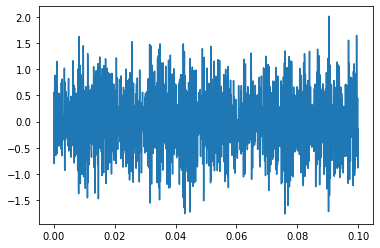

In [7]:
# plot first bearing channel
fig, ax = plt.subplots()

ax.plot(
    np.arange(0,df.shape[0], dtype='float64') / (25.6 * 10**3), # make x-axis in seconds
    df['acc_horz'] # acceleration data
)

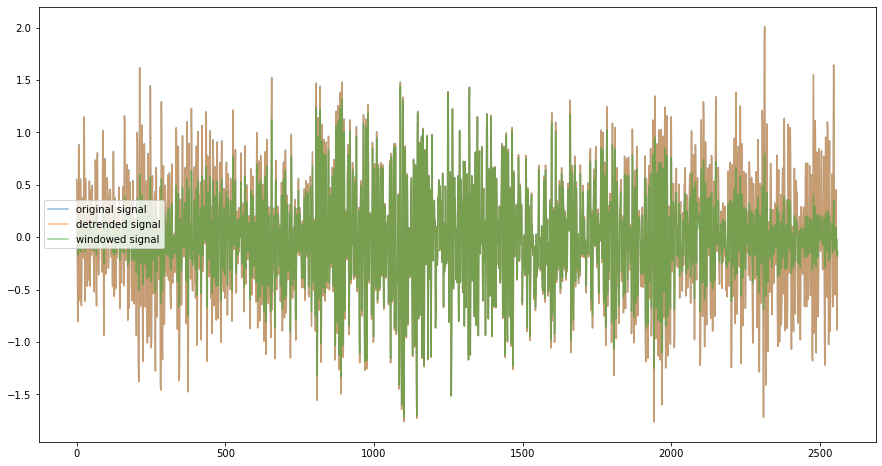

In [8]:
# practice detrending
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

plt.plot(df['acc_horz'], alpha=0.5, label='original signal')
y_detrend = signal.detrend(df['acc_horz'], type="linear")
plt.plot(y_detrend, alpha=0.5, label='detrended signal')

# apply either a hamming or kaiser windowing function
# y_detrend *= np.hamming(len(y_detrend))
y_detrend *= np.kaiser(len(y_detrend), 3)
plt.plot(y_detrend, alpha=0.5, label='windowed signal')
plt.legend(loc='center left')

Create a generic function for plotting the FFT.

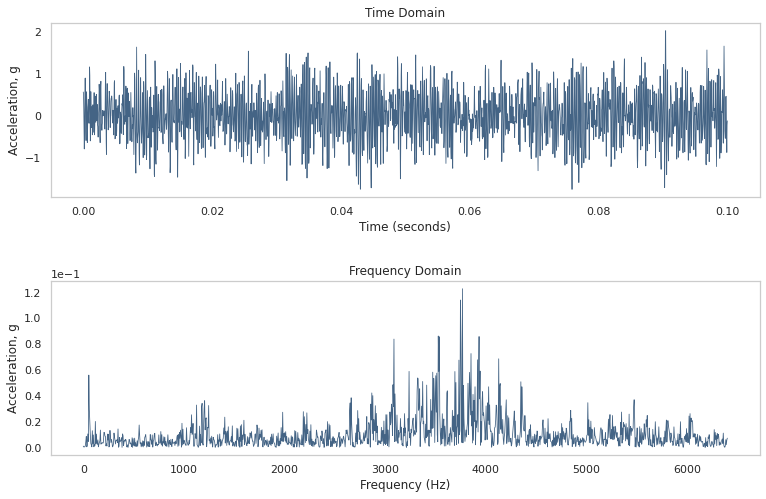

In [9]:
def create_fft(df, x_name='Time', y_name='acc_horz', sample_freq=25600.0, show_plot=True, window='hamming', beta=8):
    '''Create FFT plot from a pandas dataframe'''

    y = df[y_name].to_numpy(dtype="float64")  # convert to a numpy array
    x = np.arange(0,df.shape[0], dtype='float64') / (sample_freq)

    # parameters for plot
    T = 1.0 / sample_freq  # sample spacing
    N = len(y)  # number of sample points
    
    # do some preprocessing of the current signal
    y_detrend = y - np.mean(y)
    y_detrend = signal.detrend(y_detrend, type="constant")  # detrended signal
    
    if window == 'hamming':
        y_detrend *= np.hamming(N)  # apply a hamming window. Why? https://dsp.stackexchange.com/a/11323
    else:
        y_detrend *= np.kaiser(len(y_detrend), beta)

    # FFT on time domain signal
    yf = fftpack.rfft(y_detrend)
    yf = 2.0 / N * np.abs(yf[: int(N / 2.0)])
    xf = np.linspace(0.0, 1.0 / (2.0 * T), N // 2)/2

    if show_plot:
        # setup the seaborn plot
        sns.set(font_scale=1.0, style="whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False, sharey=False)
        fig.tight_layout(pad=5.0)

        pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)  # pick nice color for plot

        # plot time domain signal
        axes[0].plot(x, y, marker="", label="Best model", color=pal[3], linewidth=0.8)
        axes[0].set_title("Time Domain", fontdict={"fontweight": "normal"})
        axes[0].set_xlabel("Time (seconds)")
        axes[0].set_ylabel("Acceleration, g")
        # axes[0].set_yticklabels([])

        # plot the frequency domain signal
        axes[1].plot(xf, yf, marker="", label="Best model", color=pal[3], linewidth=0.8)
        axes[1].set_title("Frequency Domain", fontdict={"fontweight": "normal"})
        axes[1].set_xlabel("Frequency (Hz)")
        axes[1].set_ylabel("Acceleration, g")
        plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        

        # clean up the sub-plots to make everything pretty
        for ax in axes.flatten():
            ax.yaxis.set_tick_params(labelleft=True, which="major")
            ax.grid(False)
            
        # in case you want to save the figure (just uncomment)
        plt.savefig('time_freq_domains.png',dpi=600,bbox_inches = "tight")
        plt.show()
    
    return xf, yf

xf, yf = create_fft(df, x_name='Time', y_name='acc_horz', sample_freq=25600.0, show_plot=True, window='kaiser', beta=3)

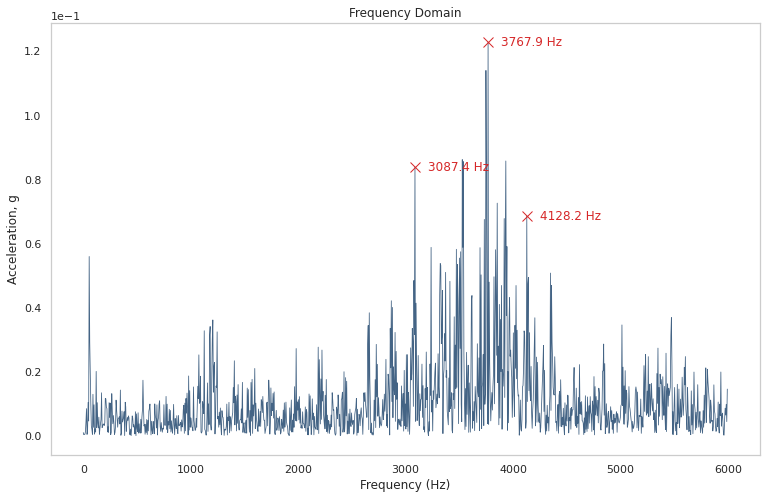

In [10]:
def plot_freq(xf, yf, max_freq_to_plot=1000, peak_height=0.0001, peak_distance=100):

    # select the index number where xf is less than a certain freq
    i = np.where(xf<max_freq_to_plot)[0][-1]
    peak_distance_index = peak_distance * i / max_freq_to_plot

    # setup the seaborn plot
    sns.set(font_scale=1.0, style="whitegrid")
    fig, axes = plt.subplots(1, 1, figsize=(12, 8), sharex=False, sharey=False)
    fig.tight_layout(pad=5.0)
    
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)  # pick nice color for plot

    # plot the frequency domain signal
    axes.plot(xf[:i], yf[:i], marker="", label="Best model", color=pal[3], linewidth=0.8)
    axes.set_title("Frequency Domain", fontdict={"fontweight": "normal"})
    axes.set_xlabel("Frequency (Hz)")
    axes.set_ylabel("Acceleration, g")
    axes.yaxis.set_tick_params(labelleft=True, which="major")
    axes.grid(False)

    peaks, _ = signal.find_peaks(yf[:i], height=peak_height, distance=peak_distance_index)
    plt.plot(xf[peaks], yf[peaks], "x", color='#d62728', markersize=10)

    for p in peaks:
        axes.text(
            x=xf[p]+max_freq_to_plot/50.0,
            y=yf[p],
            s=f"{xf[p]:.1f} Hz",
            horizontalalignment="left",
            verticalalignment="center",
            size=12,
            color="#d62728",
            rotation="horizontal",
            weight="normal",
        )

    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    plt.show()


plot_freq(xf, yf, max_freq_to_plot=6000, peak_height=0.06, peak_distance=250)

Now we'll try a different operating condition -- how about the third operating condition at 1500 RPM?

In [11]:
# third operating condition folder location
folder_bearing3_1 = folder_raw_data / 'Bearing3_1'

# let's use pandas
col_names = ['hr', 'min', 'sec', 'micro_sec', 'acc_horz', 'acc_vert']
df = pd.read_csv(folder_bearing3_1 / 'acc_00001.csv', names=col_names)

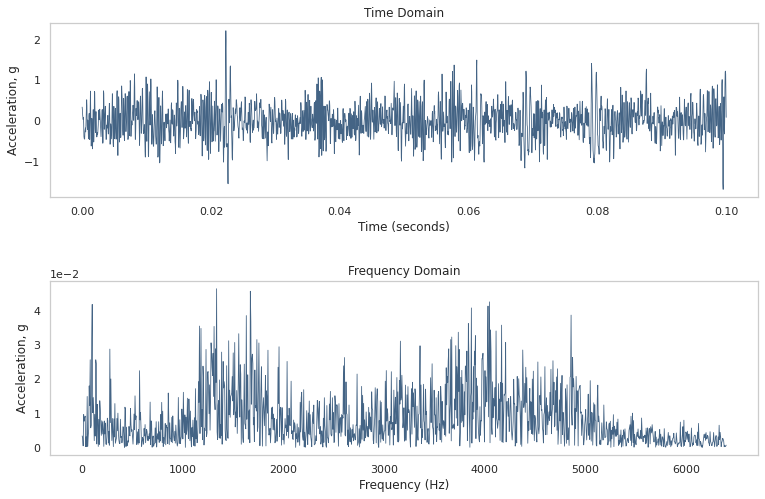

In [12]:
xf, yf = create_fft(df, x_name='Time', y_name='acc_horz', sample_freq=25600.0, show_plot=True, window='kaiser', beta=3)

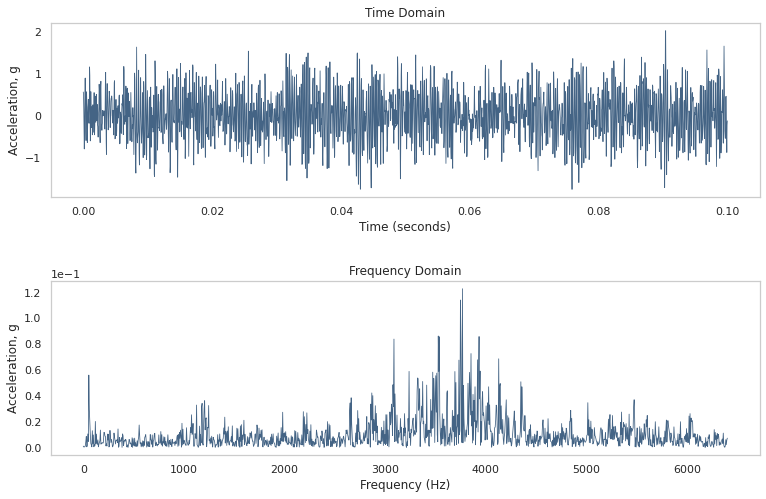

In [13]:
# compare to bearing1_1
df = pd.read_csv(folder_bearing1_1 / 'acc_00001.csv', names=col_names)
xf, yf = create_fft(df, x_name='Time', y_name='acc_horz', sample_freq=25600.0, show_plot=True, window='kaiser', beta=3)

In [14]:
len(xf)

1280

## Spectrogram
We want to build a spectrogram for bearing1_1.

First, get the name of all the files in the folder.

### Aside: Getting Acceleration Files Only

In [13]:
def create_date_dict(folder):
    # instantiate the date dictionary that will
    # hold the date/time that each signal was recorded on
    # along with the file name

    date_dict = {}

    for i, file in enumerate(os.listdir(folder)):
        if fnmatch.fnmatch(file, f'acc*.csv'):

            # get the unix timestamp for when the file was modified (http://bit.ly/2RW5cYo)
            date_created = datetime.datetime.fromtimestamp(os.path.getmtime(folder_bearing1_1 / str(file)))

            # open each csv file, read first line, and extract times
            with open(folder_bearing1_1 / file, newline='') as f:
                csv_reader = csv.reader(f)
                csv_headings = next(csv_reader)

            # help with datetime: https://realpython.com/python-datetime/
            # convert "time" string to datetime object
            time_created = datetime.time(hour=int(float(csv_headings[0])), 
                                         minute=int(float(csv_headings[1])), 
                                         second=int(float(csv_headings[2])), 
                                         microsecond=int(float(csv_headings[3]))
                                         )

            # combine date and time into a single datetime object
            combined_date = datetime.datetime.combine(date_created, time_created)
            unix_timestamp = combined_date.timestamp()
            date_nice_format = combined_date.strftime('%Y-%m-%d %H:%M:%S')

            date_dict[unix_timestamp] = [combined_date, date_nice_format, file]
    return date_dict


In [14]:
folder_bearing1_1 = folder_raw_data / 'Bearing1_1'

date_dict = create_date_dict(folder_bearing1_1)

In [15]:
date_dict

{1327356789.065664: [datetime.datetime(2012, 1, 23, 17, 13, 9, 65664),
  '2012-01-23 17:13:09',
  'acc_02722.csv'],
 1327346369.065664: [datetime.datetime(2012, 1, 23, 14, 19, 29, 65664),
  '2012-01-23 14:19:29',
  'acc_01680.csv'],
 1327345999.065664: [datetime.datetime(2012, 1, 23, 14, 13, 19, 65664),
  '2012-01-23 14:13:19',
  'acc_01643.csv'],
 1327334209.065664: [datetime.datetime(2012, 1, 23, 10, 56, 49, 65664),
  '2012-01-23 10:56:49',
  'acc_00464.csv'],
 1327334829.065664: [datetime.datetime(2012, 1, 23, 11, 7, 9, 65664),
  '2012-01-23 11:07:09',
  'acc_00526.csv'],
 1327352199.065664: [datetime.datetime(2012, 1, 23, 15, 56, 39, 65664),
  '2012-01-23 15:56:39',
  'acc_02263.csv'],
 1327356359.065664: [datetime.datetime(2012, 1, 23, 17, 5, 59, 65664),
  '2012-01-23 17:05:59',
  'acc_02679.csv'],
 1327351589.065664: [datetime.datetime(2012, 1, 23, 15, 46, 29, 65664),
  '2012-01-23 15:46:29',
  'acc_02202.csv'],
 1327332329.065664: [datetime.datetime(2012, 1, 23, 10, 25, 29, 6566

### Calculate FFT for Each Signal
We'll calculate the FFT for each signal. This will be stored in a pandas dataframe, with each new column being a new signal.

In [17]:
def build_spectrogram_df_femto(folder, date_dict, channel_name='acc_horz', col_day_increment=False,
                         col_names=['hr', 'min', 'sec', 'micro_sec', 'acc_horz', 'acc_vert']):
    '''function that builds the spectrogram data'''
    
    # date_time list
    date_list = sorted(list(date_dict.keys()))
    start_time = date_list[0] # get the star time

    # instantiate dataframe for the spectrogram
    dft = pd.DataFrame()
       
    # dictionary to store any labels
    labels_dict = {}

    # iterate through each date that samples were taken
    # date_list should be sorted from earliest to latest
    for i, unix_timestamp in enumerate(date_list):
        # convert sample_name to unix timestamp
        date_nice_format = date_dict[unix_timestamp][1]

        # open the file containing the measurements
        df = pd.read_csv(folder / date_dict[unix_timestamp][2], names=col_names)

        # create fft
        xf, yf = create_fft(df, x_name='Time', y_name=channel_name, sample_freq=25600.0, show_plot=False, window='kaiser', beta=3)
        # xf, yf = create_fft(df, x_name='Time', y_name=channel_name, sample_freq=20000.0, show_plot=False, window='kaiser', beta=3)


        # append the time increments
        time_increment_seconds = unix_timestamp-start_time
        time_increment_days = time_increment_seconds /(60 * 60 * 24)
        
        # create new column for the current sample_name FFT
        if col_day_increment == False:
            dft[date_nice_format] = yf
        if col_day_increment == True:
            dft[str(time_increment_days)] = yf

        # create new dictionary key and values to store lable info
        labels_dict[unix_timestamp] = [date_nice_format, unix_timestamp, time_increment_seconds, time_increment_days]

    dft = dft.set_index(xf, drop=True) # index as frequency (Hz)
    return dft, labels_dict

In [18]:
folder_bearing1_1 = folder_raw_data / 'Bearing1_1'

date_dict = create_date_dict(folder_bearing1_1)

df_spec, labels_dict = build_spectrogram_df_femto(folder_bearing1_1, date_dict, channel_name='acc_horz',)
df_spec.head()

,2012-01-23 09:38:46,2012-01-23 09:39:39,2012-01-23 09:39:49,2012-01-23 09:39:59,2012-01-23 09:40:09,2012-01-23 09:40:19,2012-01-23 09:40:29,2012-01-23 09:40:39,2012-01-23 09:40:49,2012-01-23 09:40:59,...,2012-01-23 17:25:09,2012-01-23 17:25:19,2012-01-23 17:25:29,2012-01-23 17:25:39,2012-01-23 17:25:49,2012-01-23 17:25:59,2012-01-23 17:26:09,2012-01-23 17:26:19,2012-01-23 17:26:29,2012-01-23 17:26:39
0.000000,0.007817,0.000947,0.001082,0.001742,0.000492,0.002904,0.003650,0.001643,0.000499,0.000133,...,0.004761,0.004630,0.005044,0.002906,0.006239,0.004456,0.002893,0.001554,0.008980,0.010347
5.003909,0.005276,0.000326,0.001004,0.000264,0.000133,0.003002,0.000917,0.001005,0.001053,0.000815,...,0.004203,0.007157,0.004584,0.008414,0.007473,0.022264,0.002244,0.005448,0.017508,0.011609
10.007819,0.000319,0.000435,0.000558,0.000407,0.000125,0.000119,0.000303,0.000466,0.000730,0.000080,...,0.011985,0.009769,0.006468,0.005432,0.002522,0.017905,0.014132,0.009838,0.010155,0.003385
15.011728,0.001471,0.000431,0.001568,0.001948,0.002663,0.004101,0.004382,0.000524,0.001006,0.002066,...,0.004428,0.003921,0.000328,0.007350,0.003377,0.002248,0.002915,0.007467,0.004491,0.010441
20.015637,0.000266,0.001185,0.002117,0.000953,0.000581,0.000229,0.001309,0.006276,0.004900,0.002970,...,0.012133,0.011108,0.004487,0.004809,0.006498,0.006856,0.005549,0.002628,0.004543,0.018265


Plot the spectrogram.

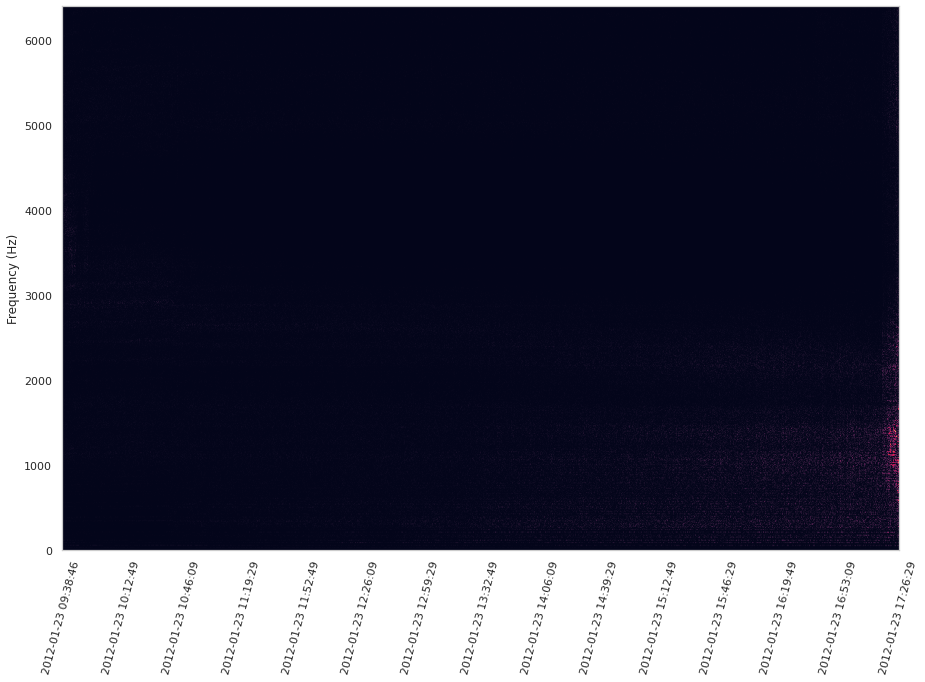

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.pcolormesh(df_spec.columns, df_spec.index, df_spec)

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::200]) # show every 100th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()

The above spectrogram is fairly "dim". 

We'll adjust the vmax to get better clarity.

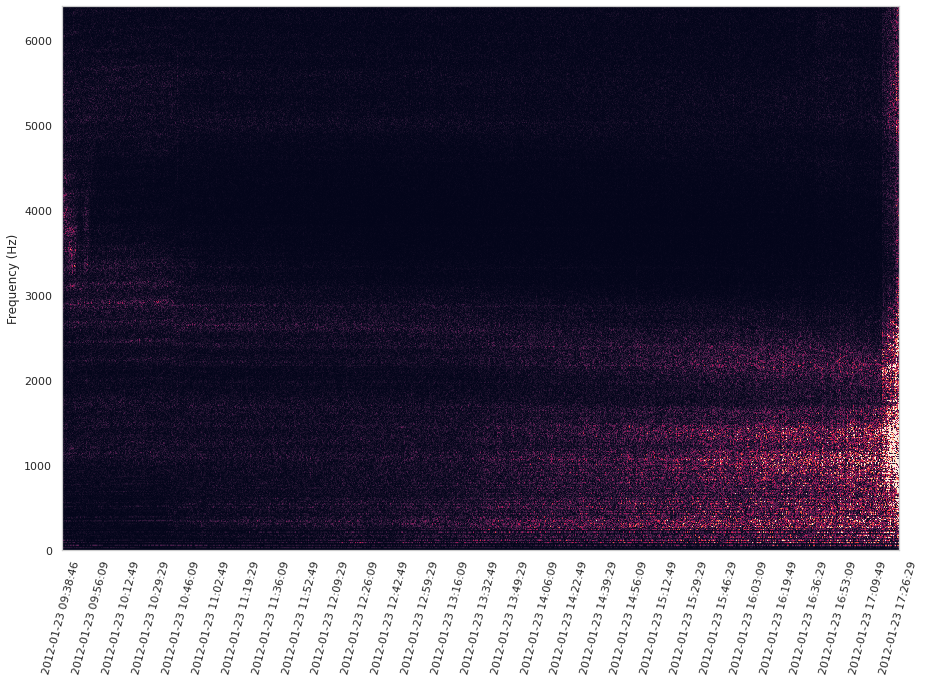

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# set vmax to 0.2
plt.pcolormesh(df_spec.columns, df_spec.index, df_spec, vmax=0.2)

ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_spec.columns[::100]) # show every 100th date on x-axis ticks
plt.xticks(rotation=75)

plt.show()

## Build Features

In [32]:
folder_bearing1_1 = folder_raw_data / 'Bearing1_1'

date_dict = create_date_dict(folder_bearing1_1)

df_spec, labels_dict = build_spectrogram_df_femto(folder_bearing1_1, date_dict, channel_name='acc_horz',)

In [34]:
df_spec.shape

(1280, 2802)

shape of max_a array: (20, 2802)


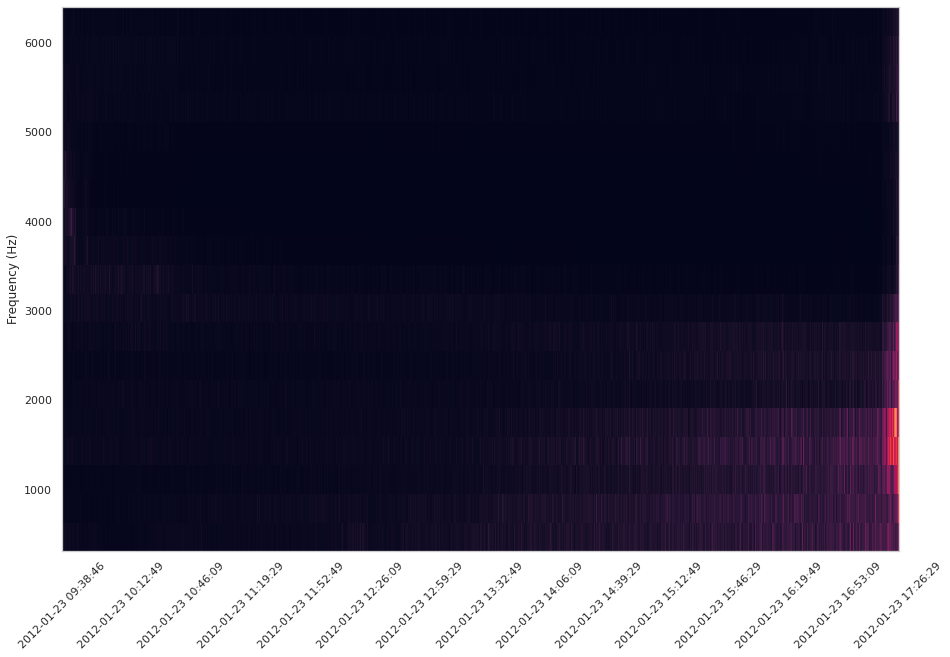

In [39]:
bucket_size = 64

df_temp = df_spec
a = np.array(df_temp) # make numpy array

# get the y-axis (frequency values)
y = np.array(df_temp.index)
y = np.max(y.reshape(-1,bucket_size),axis=1)

# get the max value for each bucket
# https://stackoverflow.com/a/15956341/9214620
max_a = np.max(a.reshape(-1,bucket_size,2802),axis=1)

print('shape of max_a array:', np.shape(max_a))

# get the mean value for each bucket
avg_a = np.mean(a.reshape(-1,bucket_size,2802),axis=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.pcolormesh(df_temp.columns, y, max_a)
ax.set_ylabel("Frequency (Hz)")
plt.xticks(df_temp.columns[::200])
plt.xticks(rotation=45)
plt.show()

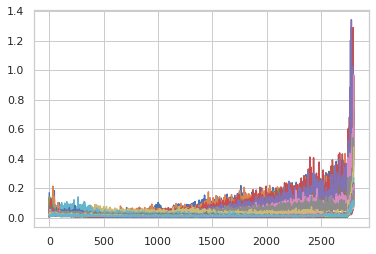

In [42]:
plt.plot(max_a.T)
plt.show()